In [113]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, root_mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

In [38]:
minors = pd.read_csv('ds4420_minors_stats.csv')

In [12]:
minors = minors.loc[~minors['Lev'].isin(['Fal', 'NCAA', 'Summ', 'Ind', 'Smr', 'Fgn', 'WRk']), :]

num_stats = minors.columns[7:30]

agg_dict = {stat:'sum' for stat in num_stats}
agg_dict['Age'] = 'max'
agg_dict['Rookie_Season'] = 'max'
agg_dict['Rookie_rOBA'] = 'max'

minors_aggregated = minors.groupby(['PlayerID', 'Year']).agg(agg_dict).reset_index()

In [25]:
minors_aggregated['Year_Weight'] = 0.5 ** (minors_aggregated['Rookie_Season'] - minors_aggregated['Year'] - 1)
minors_aggregated['Rookie_Age'] = minors_aggregated['Age'] - minors_aggregated['Year'] + minors_aggregated['Rookie_Season']

In [94]:
minors_weighted = minors_aggregated.groupby('PlayerID').agg(
    {'Rookie_Season':'max', 'Rookie_Age':'max', 'Rookie_rOBA':'max'}
).reset_index()

for stat in num_stats:
    minors_weighted = minors_weighted.merge(minors_aggregated.groupby('PlayerID').apply(
        lambda x: np.average(x[stat], weights=x['Year_Weight']), include_groups=False).reset_index(name=stat)
    )

minors_weighted['BA'] = minors_weighted['H'] / minors_weighted['AB']
minors_weighted['OBP'] = np.sum(minors_weighted[['H','BB','HBP']], axis=1) / np.sum(minors_weighted[['AB','BB','HBP','SF']], axis=1)
minors_weighted['SLG'] = minors_weighted['TB'] / minors_weighted['AB']

for stat in ['2B', '3B', 'HR', 'BB', 'SO', 'HBP', 'SF', 'IBB']:
    minors_weighted[f'{stat}_rate'] = minors_weighted[stat] / minors_weighted['PA']

keep_cols = ['PlayerID', 'Rookie_Season', 'Rookie_rOBA', 'Rookie_Age', 'BA', 'OBP', 'SLG', '2B_rate', '3B_rate', 'HR_rate', 
             'BB_rate', 'SO_rate', 'HBP_rate', 'SF_rate', 'IBB_rate']

minors_weighted = minors_weighted.loc[:, keep_cols].dropna()

feats = keep_cols[3:]


In [95]:
validation_df = minors_weighted.loc[minors_weighted['Rookie_Season'] == 2025, :]
modeling_df = minors_weighted.loc[minors_weighted['Rookie_Season'] < 2025, :]

In [96]:
train_df, test_df = train_test_split(modeling_df, test_size=0.2)

In [99]:
scaler = StandardScaler()

train_df_scaled = train_df.copy()
train_df_scaled.loc[:, keep_cols[3:]] = scaler.fit_transform(train_df_scaled.loc[:, feats])

test_df_scaled = test_df.copy()
test_df_scaled.loc[:, keep_cols[3:]] = scaler.transform(test_df_scaled.loc[:, feats])

validation_df_scaled = validation_df.copy()
validation_df_scaled.loc[:, keep_cols[3:]] = scaler.transform(validation_df_scaled.loc[:, feats])

In [100]:
X_train = train_df_scaled[feats].values
y_train = train_df_scaled['Rookie_rOBA'].values.reshape(-1, 1)

X_test = test_df_scaled[feats].values
y_test = test_df_scaled['Rookie_rOBA'].values.reshape(-1, 1)

In [101]:
def f(X, W1, W2):
    H = np.maximum(0, X.dot(W1))
    return H.dot(W2) 

def training_loop(X, y, hidden=10, step_size=0.01, epochs=100000):
    n, d = X.shape
    W1 = np.random.randn(d, hidden) * 0.1
    W2 = np.random.randn(hidden, 1) * 0.1
    errors = []

    for epoch in range(epochs):
        H = np.maximum(0, X @ W1) 
        y_pred = H @ W2
        error = np.mean((y_pred - y) ** 2)
        errors.append(error)

        dY = (2/n) * (y_pred - y)
        dW2 = H.T @ dY

        dH = dY @ W2.T
        dH[H <= 0] = 0

        dW1 = X.T @ dH

        W1 -= step_size * dW1
        W2 -= step_size * dW2

    return W1, W2, errors

W1, W2, errors = training_loop(X_train, y_train)
y_pred = np.maximum(0, X_test @ W1) @ W2

In [120]:
r2 = r2_score(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)
r2, rmse

(-4.557799709544554, 0.09194193392365427)

In [119]:
naive_preds = np.ones_like(y_test) * np.mean(y_train)
naive_rmse = root_mean_squared_error(y_test, naive_preds)
naive_rmse

0.03920073694189566

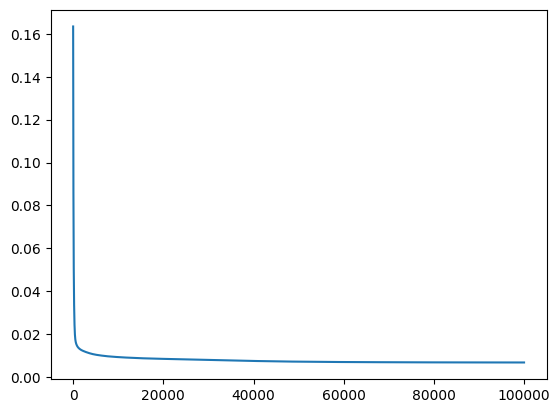

In [108]:
plt.plot(errors)
plt.show()

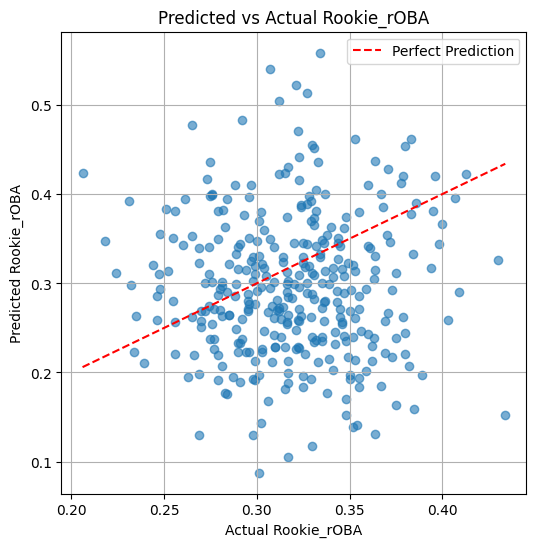

In [121]:
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Perfect Prediction')
plt.xlabel('Actual Rookie_rOBA')
plt.ylabel('Predicted Rookie_rOBA')
plt.title('Predicted vs Actual Rookie_rOBA')
plt.legend()
plt.grid(True)
plt.show()

In [122]:
validation_pred = np.maximum(0, validation_df_scaled[feats].values @ W1) @ W2

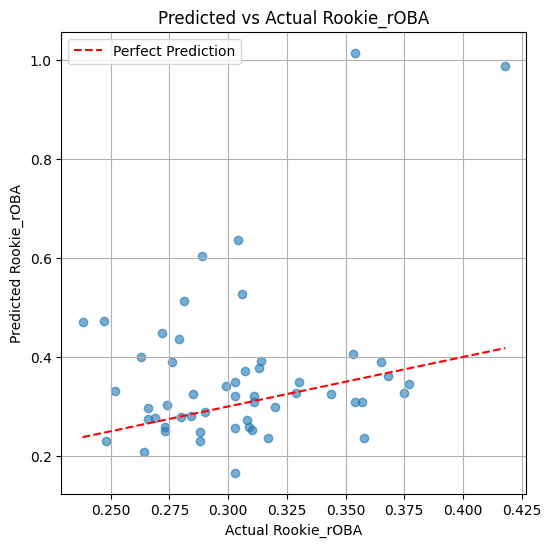

In [124]:
plt.figure(figsize=(6,6))
plt.scatter(validation_df_scaled['Rookie_rOBA'], validation_pred, alpha=0.6)
plt.plot([validation_df_scaled['Rookie_rOBA'].min(), validation_df_scaled['Rookie_rOBA'].max()], 
         [validation_df_scaled['Rookie_rOBA'].min(), validation_df_scaled['Rookie_rOBA'].max()], 'r--', label='Perfect Prediction')
plt.xlabel('Actual Rookie_rOBA')
plt.ylabel('Predicted Rookie_rOBA')
plt.title('Predicted vs Actual Rookie_rOBA')
plt.legend()
plt.grid(True)
plt.show()